In [3]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gdecomp
import pandas as pd

## Gaussian Decomposition

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Sum of Two Gaussians')

Text(0.5, 0, 'X-axis')

Text(0, 0.5, 'Y-axis')

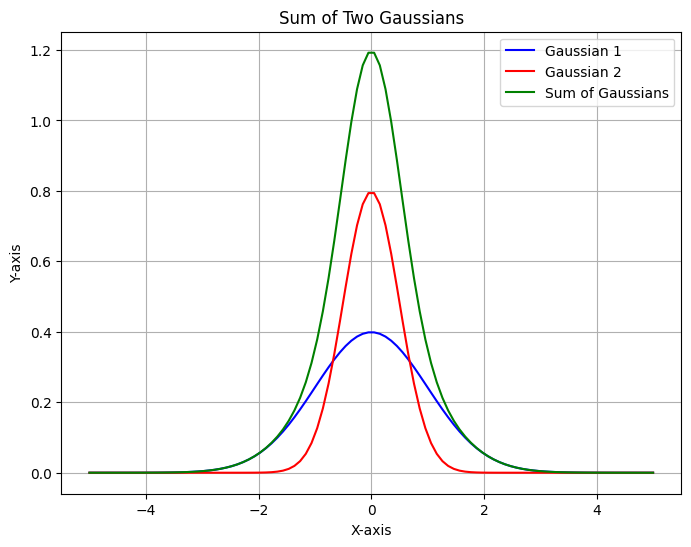

In [5]:
%matplotlib inline
# Define the Gaussian function
def gaussian(x, mean, std_dev, amp = 1):
    return amp * np.exp(-(x - mean)**2 / (2 * std_dev**2)) / (std_dev * np.sqrt(2 * np.pi))

# Set up x-values and Gaussian parameters
x = np.linspace(-5, 5, 100)
mean1, std_dev1 = 0, 1
mean2, std_dev2 = 0, 0.5

# Calculate the Gaussian functions
gaussian1 = gaussian(x, mean1, std_dev1)
gaussian2 = gaussian(x, mean2, std_dev2)

# Calculate the sum of Gaussians
sum_of_gaussians = gaussian1 + gaussian2

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, gaussian1, label='Gaussian 1', color='blue')
plt.plot(x, gaussian2, label='Gaussian 2', color='red')
plt.plot(x, sum_of_gaussians, label='Sum of Gaussians', color='green')
plt.legend()
plt.title('Sum of Two Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)

[[18.87853616 49.5         6.53849514]]
0


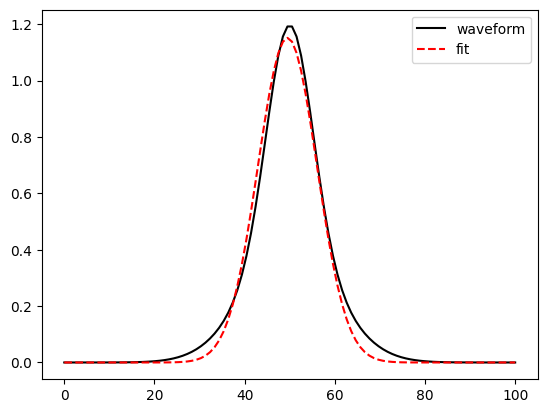

In [6]:
x = np.linspace(0, 100, 100)
out = gdecomp.GaussianDecomposition(sum_of_gaussians)
out = np.reshape(out, (-1, 3))
print(out)
fit = np.zeros(sum_of_gaussians.size)
for i in range(out.shape[0]):
    print(i)
    fit += gaussian(x, out[i, 1], out[i, 2], out[i, 0])

line1 = plt.plot(x, sum_of_gaussians, color="k", label="waveform")
line2 = plt.plot(x, fit, color="r", linestyle="--", label="fit")
plt.legend(loc="upper right")

# Maxquant MSMS

## Preprocessing and matching with evidence.txt

In [14]:
# path to MaxQuant results (evidence.txt) of the same RAW file, used for constructing reference dictionary
maxquant_file = (
    "/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/combined/txt/evidence.txt"
)
maxquant_msms_RTpred_file = "msms_with_predRT.txt"
# path to the data input in mzML format, containing only MS1 level data
msconvert_file = (
    "/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/msconvert_profile.mzML"
)
MS1Scans_NoArray_file = (
    "/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/MS1Scans_NoArray.csv"
)
Maxquant_result = pd.read_csv(filepath_or_buffer=maxquant_file, sep="\t")
Maxquant_msms = pd.read_csv(filepath_or_buffer=maxquant_msms_RTpred_file, sep="\t")
MS1Scans_NoArray = pd.read_csv(MS1Scans_NoArray_file)

In [8]:
msms_modseq_charge = (
    Maxquant_msms.groupby(by=["Modified sequence", "Charge"]).first().reset_index()
)
evidence_modseq_charge = (
    Maxquant_result.groupby(by=["Modified sequence", "Charge"])["Intensity"]
    .sum()
    .reset_index()
)

In [9]:
from optimization.dictionary import LoadMZML
import pickle
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
# Load MS1 scans from pkl or mzml file
try:
    with open(msconvert_file[:-5] + ".pkl", "rb") as f:
        MS1Scans = pickle.load(f)
    print("Load pre-stored pickle results")
except:
    print("Pickle result not found, load mzml file.")
    MS1Scans = LoadMZML(msconvert_file)
    MS1Scans.to_pickle(msconvert_file[:-5] + ".pkl")

Load pre-stored pickle results


<module 'utils.metrics' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/metrics.py'>

10.128148591555036

Green line shows deltaRT 95
Data:  Retention time predicted_RT , slope =  0.969 , intercept =  0.987 , PearsonR =  0.987 , SpearmanR =  0.989


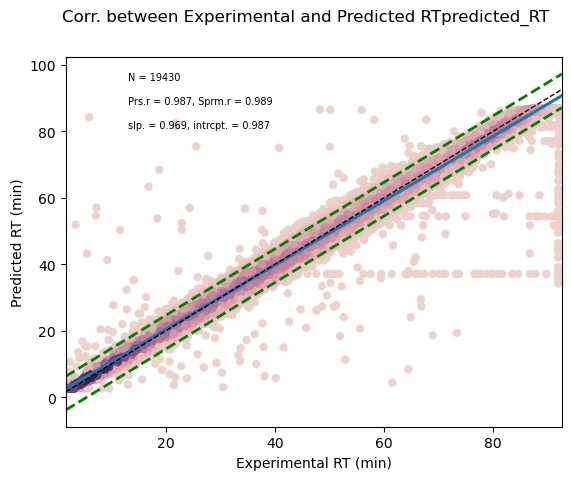

In [15]:
from utils.metrics import RT_metrics
import utils.metrics

MS1Scans_NoArray["ScanIndex"] = MS1Scans_NoArray.index
# Append predicted RT to maxquant result
Maxquant_result = pd.merge(
    left=Maxquant_result,
    right=msms_modseq_charge[["Modified sequence", "Charge", "predicted_RT"]],
    on=["Modified sequence", "Charge"],
    how="left",
)
Maxquant_result["RT_delta"] = (
    Maxquant_result["Retention time"] - Maxquant_result["predicted_RT"]
)
Maxquant_result.to_csv(
    "/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/combined/txt/evidence_withPredRT.txt",
    sep="\t",
)
# evaluate RT prediction
reload(utils.metrics)

RT_eval = RT_metrics(
    RT_obs=Maxquant_result["Retention time"], RT_pred=Maxquant_result["predicted_RT"]
)
RT_eval.CalcDeltaRTwidth()
RT_eval.PlotRTScatter()

In [23]:
Maxquant_result.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'Experiment', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Resolution', 'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Match time difference',
       'Match m/z difference', 'Match q-value', 'Match score',
       'Number of data points', 'Number of scans', 'Number of isotopic peaks',
       'PIF', 'Fraction of total spectrum', 'Base 

In [22]:
view = Maxquant_result[
    [
        "Modified sequence",
        "Proteins",
        "Charge",
        "Reverse",
        "predicted_RT",
        "Intensity",
        "Calibrated retention time start",
        "Calibrated retention time finish",
        "Retention time",
        "RT_delta",
    ]
]

In [21]:
test = view.groupby(by=["Modified sequence", "Charge"]).count()

In [ ]:
msms_modseq_charge_scan = pd.merge_asof(
    left=msms_modseq_charge.sort_values(by="predicted_RT"),
    right=MS1Scans_NoArray[["ScanIndex", "starttime"]],
    # right_index=True,
    direction="nearest",
    left_on="predicted_RT",
    right_on="starttime",
    suffixes=["", "_scan"],
)
cols_to_preserved = [
    "Modified sequence",
    "Charge",
    "predicted_RT",
    "ScanIndex",
    "Retention time",
    "Calibrated retention time start",
    "Calibrated retention time finish",
]
evidence_modseq_charge_predRT_scan = pd.merge(
    left=evidence_modseq_charge,
    right=msms_modseq_charge_scan[
        ["Modified sequence", "Charge", "predicted_RT", "ScanIndex", "Retention time"]
    ],
    on=["Modified sequence", "Charge"],
)

In [16]:
from optimization.dictionary import CalcModpeptIsopattern

msms_modseq_charge_scan["IsoMZ"], msms_modseq_charge_scan["IsoAbundance"] = zip(
    *msms_modseq_charge_scan.apply(
        lambda row: CalcModpeptIsopattern(
            modpept=row["Modified sequence"], charge=row["Charge"], ab_thres=0.01
        ),
        axis=1,
    )
)
msms_modseq_charge_scan = pd.merge_asof(
    left=msms_modseq_charge_scan.sort_values("Retention time"),
    right=MS1Scans_NoArray[["ScanIndex", "starttime"]],
    left_on="Retention time",
    right_on="starttime",
    direction="nearest",
    suffixes=["", "_true"],
)
msms_modseq_charge_scan.sort_values(by="id", inplace=True)

In [34]:
import logging
from optimization.dictionary import locate_RT_range
import optimization.dictionary

reload(optimization.dictionary)
reload(logging)
logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s", level=logging.DEBUG
)
precursor_idx = 20
locate_RT_range(
    precursorRow=msms_modseq_charge_scan.iloc[precursor_idx, :],
    MS1Scans=MS1Scans,
    search_range=100,
    ScanIdx=msms_modseq_charge_scan["ScanIndex"].iloc[precursor_idx],
)

<module 'optimization.dictionary' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/optimization/dictionary.py'>

<module 'logging' from '/home/zixuanxiao/miniconda3/lib/python3.10/logging/__init__.py'>

2023-10-25 13:41:21,195 - root - DEBUG - Start scan = 2281, Scan edge = (2181, 2381)
2023-10-25 13:41:21,205 - root - DEBUG - Precursor 24 is not observed in seeding Scan 2281, start searching scan 2280 and 2282.
2023-10-25 13:41:21,218 - root - DEBUG - Precursor 24 not observed in scan 2280 and 2282, search with increased step


2023-10-25 13:41:21,234 - root - DEBUG - Precursor 24 not observed in scan 2279 and 2283, search with increased step
2023-10-25 13:41:21,246 - root - DEBUG - Precursor 24 not observed in scan 2278 and 2284, search with increased step
2023-10-25 13:41:21,264 - root - DEBUG - Precursor 24 not observed in scan 2277 and 2285, search with increased step
2023-10-25 13:41:21,280 - root - DEBUG - Precursor 24 not observed in scan 2276 and 2286, search with increased step
2023-10-25 13:41:21,290 - root - DEBUG - Precursor 24 not observed in scan 2275 and 2287, search with increased step
2023-10-25 13:41:21,306 - root - DEBUG - Precursor 24 not observed in scan 2274 and 2288, search with increased step
2023-10-25 13:41:21,319 - root - DEBUG - Precursor 24 not observed in scan 2273 and 2289, search with increased step
2023-10-25 13:41:21,329 - root - DEBUG - Precursor 24 not observed in scan 2272 and 2290, search with increased step
2023-10-25 13:41:21,338 - root - DEBUG - Precursor 24 not observ

(2317, 2319)

In [ ]:
import logging

reload(logging)
logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s", level=logging.INFO
)
sample = msms_modseq_charge_scan.sample(400)
sample["inferred_start_scan"] = 0
sample["inferred_end_scan"] = 0
for precursor_idx in sample.index:
    precursor_idx
    sample.loc[
        precursor_idx, ["inferred_start_scan", "inferred_end_scan"]
    ] = locate_RT_range(
        precursorRow=sample.loc[precursor_idx, :],
        MS1Scans=MS1Scans,
        search_range=100,
        ScanIdx=sample.loc[precursor_idx, "ScanIndex"],
    )

In [36]:
sample["IsInferCorrect"] = (
    sample["ScanIndex_true"] >= sample["inferred_start_scan"]
) & (sample["ScanIndex_true"] <= sample["inferred_end_scan"])
sample["IsInferCorrect"].sum()
sample["RT_error_by_scan"] = sample["ScanIndex"] - sample["ScanIndex_true"]
sample["RT_error_by_scan"].describe()

145

count     400.000000
mean       13.700000
std       189.575175
min      -233.000000
25%       -53.000000
50%         1.000000
75%        61.250000
max      3307.000000
Name: RT_error_by_scan, dtype: float64

<module 'result_analysis.plot' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/plot.py'>

Data:  Retention length , slope =  0.001 , intercept =  0.469 , PearsonR =  0.045 , SpearmanR =  0.082


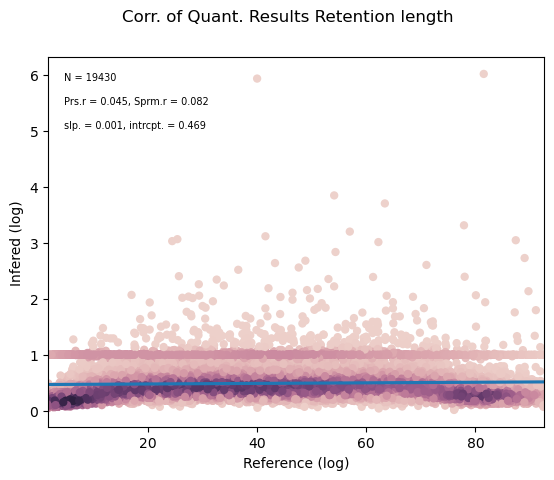

(array([0.50913458, 0.47350376, 0.47111839, ..., 0.49820993, 0.49116921,
        0.49120133]),
 array([0.20372458, 0.21981376, 0.01813839, ..., 0.11592993, 0.24551079,
        0.04449867]),
 (array([    0,     1,     2, ..., 19427, 19428, 19429]),))

In [56]:
from result_analysis.result_analysis import PlotCorr
import result_analysis.result_analysis

reload(result_analysis.result_analysis)
PlotCorr(
    Maxquant_result["Retention time"],
    Maxquant_result["Retention length"],
    filter_thres=0,
    show_diag=False,
    log=False,
)

## Elution inference

# In silico digestion

## isotope envelope calculation

In [9]:
digest_path = "/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/in_silico_digest.tsv"
digest_out_path = (
    "/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/obs_digest_unique_seq.tsv"
)
# path to the data input in mzML format, containing only MS1 level data
msconvert_file = (
    "/mnt/cmnfs/proj/ORIGINS/data/protMSD/GCF_profile/msconvert_profile.mzML"
)
digest = pd.read_csv(digest_path, sep="\t")

<Axes: >

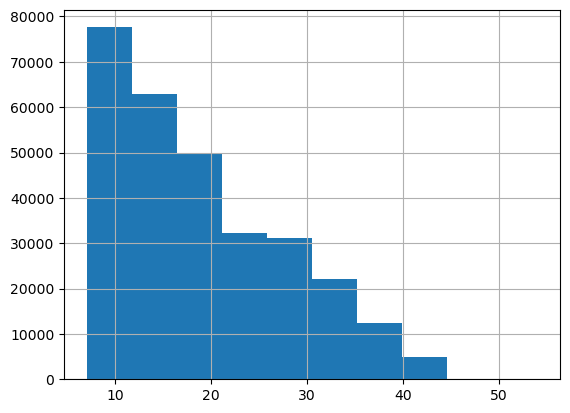

In [10]:
digest_unique_seq = digest.groupby(["Sequence"]).first().reset_index()
obs_digest_unique_seq = digest_unique_seq[
    (digest_unique_seq["Peptide_mass"] > 300)
    & (digest_unique_seq["Peptide_mass"] < 4600)
    & (digest_unique_seq["Peptide_size"] >= 7)
]
obs_digest_unique_seq.Peptide_size.hist()

<Axes: >

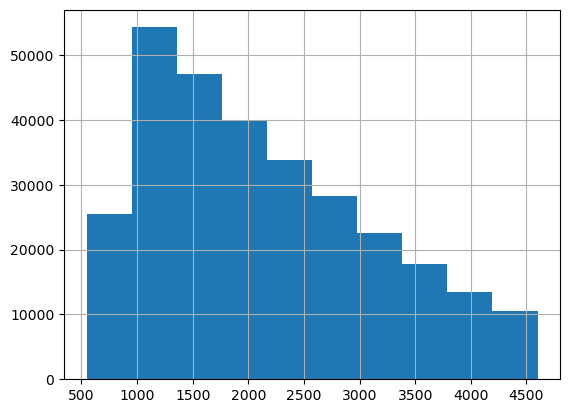

In [11]:
obs_digest_unique_seq.Peptide_mass.hist()

In [12]:
obs_digest_unique_seq.loc[:, "Peptide_mass_round2"] = np.round(
    obs_digest_unique_seq["Peptide_mass"], 2
)
obs_digest_unique_seq.loc[:, "Peptide_mass_round3"] = np.round(
    obs_digest_unique_seq["Peptide_mass"], 3
)

In [13]:
obs_digest_unique_seq.columns

Index(['Sequence', 'Original_header', 'No_peptide', 'Enzyme', 'Cleaving_pos',
       'Peptide_size', 'Peptide_mass', 'pI', 'Peptide_mass_round2',
       'Peptide_mass_round3'],
      dtype='object')

In [14]:
unique_mono2_seq = (
    obs_digest_unique_seq.groupby("Peptide_mass_round2")
    .agg({"Sequence": "count"})
    .reset_index()
)
unique_mono3_seq = (
    obs_digest_unique_seq.groupby("Peptide_mass_round3")
    .agg({"Sequence": "count"})
    .reset_index()
)

In [15]:
unique_mono2_seq.loc[unique_mono2_seq["Sequence"] > 1, "Sequence"].describe()
unique_mono3_seq.loc[unique_mono3_seq["Sequence"] > 1, "Sequence"].describe()

count    59573.000000
mean         4.204539
std          3.070116
min          2.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         42.000000
Name: Sequence, dtype: float64

count    47788.000000
mean         2.994810
std          2.160483
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         39.000000
Name: Sequence, dtype: float64